## Datos para la predicción de género en películas

![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/moviegenre.png)

En este proyecto se usará un conjunto de datos de géneros de películas. Cada observación contiene el título de una película, su año de lanzamiento, la sinopsis o plot de la película (resumen de la trama) y los géneros a los que pertenece (una película puede pertenercer a más de un género). Por ejemplo:
- Título: 'How to Be a Serial Killer'
- Plot: 'A serial killer decides to teach the secrets of his satisfying career to a video store clerk.'
- Generos: 'Comedy', 'Crime', 'Horror'

La idea es que usen estos datos para predecir la probabilidad de que una película pertenezca, dada la sinopsis, a cada uno de los géneros.

Agradecemos al profesor Fabio González, Ph.D. y a su alumno John Arevalo por proporcionar este conjunto de datos. Ver https://arxiv.org/abs/1702.01992

In [1]:
!pip install unidecode
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 6.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Importación librerías
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer
import re
from unidecode import unidecode
import spacy
import nltk
from nltk.stem.snowball import SnowballStemmer
snow_stemmer = SnowballStemmer('english')
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
plt.style.use("ggplot")
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Carga de la base de datos

In [3]:
dt= pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0).reset_index().drop("index",axis=1)

# Visualización de la base de datos

In [4]:
dt.head()

,year,title,plot,genres,rating
0,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
1,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
2,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
3,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
4,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


## Tamaño de la  base de datos

In [5]:
dt.shape

(7895, 5)

Se descartan las variables que no aportan al proyecto

In [6]:
dt=dt[["plot","genres"]]
dt.head()

,plot,genres
0,most is the story of a single father who takes...,"['Short', 'Drama']"
1,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']"
2,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']"
3,"in a friday afternoon in new york , the presi...",['Drama']
4,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']"


# Tipos de variables

In [7]:
dt.dtypes

plot      object
genres    object
dtype: object

# Peso de la base de datos

In [8]:
import sys
print("La base de datos tiene un peso de ",sys.getsizeof(dt)," bytes")

La base de datos tiene un peso de  7045029  bytes


# Cantidad de filas vacias en la base de datos

In [9]:
dt.isnull().sum()

plot      0
genres    0
dtype: int64

## Preprocesamiento

In [10]:
def preprocess(text,min_len=2, max_len=23):
    pat = re.compile(r"[^a-z ]")
    spaces = re.compile(r"\s{2,}")

    # Normalizamos el texto
    norm_text = unidecode(text)
    doc = nlp(norm_text)

    # Eliminamos stopwords
    filtered_tokens = filter(lambda token: not token.is_stop, doc )

    # Filtramos palabras por longitud
    filtered_tokens2 = filter(lambda token: len(token) >= min_len
                              and len(token) <= max_len, filtered_tokens)

    # Obtenemos los lemmas de cada token
    lemmas = map(lambda token: token.lemma_, filtered_tokens2 )
    stem = map( lambda token: snow_stemmer.stem(token), lemmas )
    lemma_text = " ".join(stem)

    # Quitamos grafía
    lower_text = lemma_text.lower()

    # Eliminamos caracteres especiales
    clean_text = re.sub(pat, "", lower_text)

    # Eliminamos espacios duplicados
    spaces_text = re.sub(spaces, " ", clean_text)
    return spaces_text.strip()
prepo_text=list(nlp.pipe(dt["plot"].apply(preprocess).tolist(), n_process=-1))

In [11]:
dt['preprocessed_plot'] = [doc.text for doc in prepo_text]

#  Preprocesamiento Variable objetivo

In [12]:
dt["genres"] = dt["genres"].apply(lambda x: x.replace('[','').replace(']','').replace("\'",''))
dt.head()

,plot,genres,preprocessed_plot
0,most is the story of a single father who takes...,"Short, Drama",stori singl father take year old son work rail...
1,a serial killer decides to teach the secrets o...,"Comedy, Crime, Horror",serial killer decid teach secret satisfi caree...
2,"in sweden , a female blackmailer with a disfi...","Drama, Film-Noir, Thriller",sweden femal blackmail disfigur facial scar me...
3,"in a friday afternoon in new york , the presi...",Drama,friday afternoon new york presid tredway corpo...
4,"in los angeles , the editor of a publishing h...","Action, Crime, Thriller",los angel editor publish hous carol hunnicut g...


In [13]:
genres_df = dt['genres'].str.get_dummies(sep=', ')
data = dt.drop(['genres','preprocessed_plot'], axis=1)
data = pd.concat([dt, genres_df], axis=1)
data.head()

,plot,genres,preprocessed_plot,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,...,Musical,Mystery,News,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,most is the story of a single father who takes...,"Short, Drama",stori singl father take year old son work rail...,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,a serial killer decides to teach the secrets o...,"Comedy, Crime, Horror",serial killer decid teach secret satisfi caree...,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,"in sweden , a female blackmailer with a disfi...","Drama, Film-Noir, Thriller",sweden femal blackmail disfigur facial scar me...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,"in a friday afternoon in new york , the presi...",Drama,friday afternoon new york presid tredway corpo...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"in los angeles , the editor of a publishing h...","Action, Crime, Thriller",los angel editor publish hous carol hunnicut g...,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


# Embedding de la variable plot con limpieza de tokens

In [14]:
vect = TfidfVectorizer(sublinear_tf=True, max_df=0.95, min_df=0.03).fit(dt.preprocessed_plot)
display(vect)

features = vect.transform(dt.preprocessed_plot).toarray()
display(features.shape)


TfidfVectorizer(max_df=0.95, min_df=0.03, sublinear_tf=True)

(7895, 280)

In [33]:
emb=[]
target=[]
for i in range(data.shape[0]):
  for j in data.genres[i].split(', '):
    if j!="News":
      emb.append(features[i])
      target.append(j)
emb=np.array(emb)
target=np.array(target)
print(emb.shape,target.shape)

(21569, 280) (21569,)


In [16]:
target=pd.get_dummies(target)
#gen=target.columns
#target=target.to_numpy()

In [34]:
X_train, X_test, y_train, y_test = train_test_split( emb, target, test_size=0.15, random_state=42,stratify=target)

In [35]:
print(y_train.shape,y_test.shape)

(18333,) (3236,)


In [51]:
from scipy.stats import halfnorm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
logreg = LogisticRegression(class_weight="balanced",solver="saga",multi_class="multinomial",tol=1e-1,max_iter=30)
space = dict()
space['C'] =  halfnorm(loc=0, scale=0.5)
cv = StratifiedKFold(n_splits=3, random_state=1,shuffle=True)
gsearch = RandomizedSearchCV(logreg, param_distributions=space, n_iter=20,  n_jobs=-1, cv=cv, random_state=1,scoring=make_scorer(roc_auc_score, greater_is_better=True),verbose=4).fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [52]:
model = gsearch.best_estimator_

In [59]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, model.predict_proba(X_test), average="macro",multi_class='ovr')

0.7672987808785401

In [64]:
from sklearn.metrics import classification_report
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

      Action       0.13      0.10      0.11       195
   Adventure       0.12      0.06      0.08       154
   Animation       0.04      0.13      0.06        39
   Biography       0.09      0.25      0.14        56
      Comedy       0.24      0.05      0.08       457
       Crime       0.21      0.20      0.20       217
 Documentary       0.21      0.46      0.29        63
       Drama       0.38      0.05      0.09       595
      Family       0.13      0.18      0.15       102
     Fantasy       0.06      0.07      0.06       106
   Film-Noir       0.05      0.40      0.09        25
     History       0.03      0.10      0.05        41
      Horror       0.21      0.31      0.25       143
       Music       0.04      0.16      0.07        51
     Musical       0.04      0.17      0.07        41
     Mystery       0.09      0.14      0.11       114
     Romance       0.27      0.25      0.26       284
      Sci-Fi       0.18    

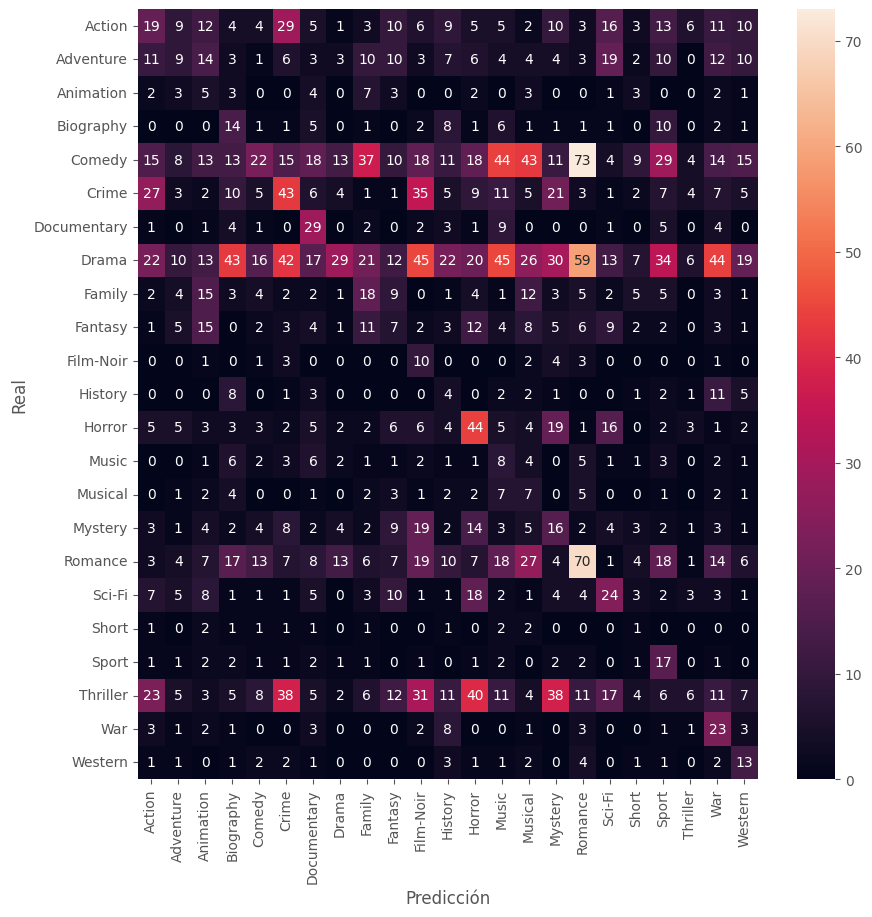

In [74]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predictions)
cm = pd.DataFrame(data=cm, columns=np.unique(y_test), index=np.unique(y_test))
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt=".0f", ax=ax)
ax.set_xlabel("Predicción")
ax.set_ylabel("Real")
fig.show()


In [69]:
y_test

array(['Drama', 'Thriller', 'Western', ..., 'Thriller', 'Music', 'Drama'],
      dtype='<U11')

In [70]:
predictions

array(['Romance', 'Music', 'Comedy', ..., 'Crime', 'Romance', 'Biography'],
      dtype='<U11')

In [72]:
np.unique(y_test)

array(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western'],
      dtype='<U11')